### <a id='import'>1. Imports and Initial Setup</a>

In [293]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier

In [294]:
data = pd.read_csv("D:/data science/project_iiml/dataset.csv.csv")
# Since we had failed payments on price = null, so we are removing these values
data= data[(data.price != 0)]

### <a id='eda'>2. Exploratory data analysis</a>

In [295]:
data.columns

Index(['created', 'device_name', 'device_os_version', 'country', 'city_id',
       'lat', 'lng', 'real_destination_lat', 'real_destination_lng', 'user_id',
       'order_id', 'order_try_id', 'distance', 'ride_distance', 'price',
       'ride_price', 'price_review_status', 'price_review_reason',
       'is_successful_payment', 'name', 'card_bin', 'failed_attempts'],
      dtype='object')

In [296]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242110 entries, 0 to 304052
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   created                242110 non-null  object 
 1   device_name            242110 non-null  object 
 2   device_os_version      242110 non-null  object 
 3   country                242109 non-null  object 
 4   city_id                241850 non-null  float64
 5   lat                    242110 non-null  float64
 6   lng                    242110 non-null  float64
 7   real_destination_lat   242086 non-null  float64
 8   real_destination_lng   242086 non-null  float64
 9   user_id                242110 non-null  int64  
 10  order_id               242110 non-null  int64  
 11  order_try_id           242110 non-null  int64  
 12  distance               242110 non-null  int64  
 13  ride_distance          242110 non-null  int64  
 14  price                  242110 non-nu

### <a id='eda'>Encoding of Country and price_review_reason Columns</a>

In [297]:
countries = pd.DataFrame(data.country.unique(), columns = ['country'])
countries['cd'] = countries.index
countries

,country,cd
0,ee,0
1,ua,1
2,lv,2
3,hu,3
4,ge,4
5,lt,5
6,mt,6
7,pl,7
8,za,8
9,fi,9


In [298]:
data = pd.merge(data, countries, on='country', how='left')

In [299]:
reasons = pd.DataFrame(data.price_review_reason.unique(), columns = ['price_review_reason'])
reasons['reason_cd'] = reasons.index
reasons

,price_review_reason,reason_cd
0,NaN,0
1,price_calculation_warnings,1
2,price_too_high,2
3,calculation_failed,3


In [300]:
data = pd.merge(data, reasons, on='price_review_reason', how='left')

### <a id='f2'>4. Feature - price_delta</a>

Here we compute the difference between the ride price and presented price for the order, and check its relation with order success/failure.<br>
Since ride price and presented price could be different because of the discount coupons applied by the
rider, let's identify chances of failures when prices match and mismatch.

Feature to calculate the delta between the ride price and presented price

In [301]:
data['price_delta'] = data['ride_price'] - data['price']

In [302]:
# Checking the distribution of price delta

data.price_delta.describe()

count    242110.000000
mean         13.904459
std          75.174977
min        -983.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        2500.000000
Name: price_delta, dtype: float64

In [303]:
# Value at 95 percentile for price delta

data.price_delta.quantile(0.95)

100.0

<AxesSubplot: >

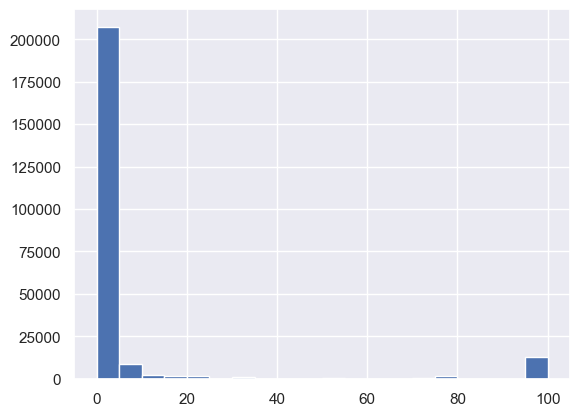

In [304]:
# Histogram for price delta with values within 100 unit (to remove skeweness)

data[(data.price_delta >= 0) & (data.price_delta <= 100)]['price_delta'].hist(bins = 20)

We can see for most of the orders the delta is very low. Let's see the distribution of orders at varied values of price delta - [less than 1, 0-100, more than 100]

Density plot to visualize the distribution of orders where price delta is less than 1 unit and see how it relates to successful/failed orders

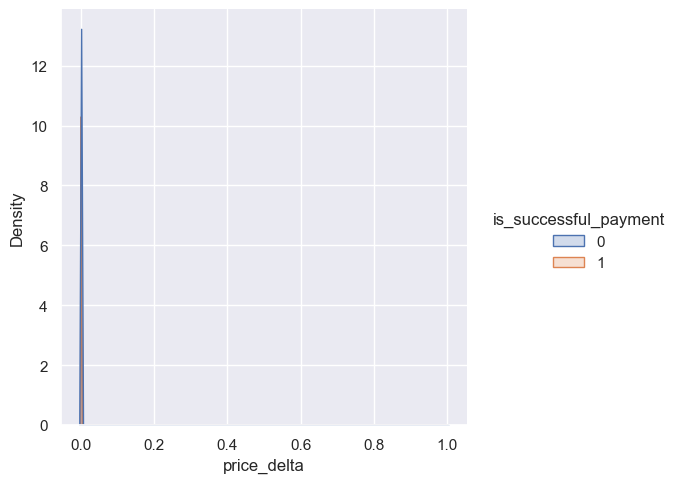

In [305]:
sns.set(style="darkgrid")

data_slim = data[(data.price_delta < 1) & (data.price_delta > -1)]\
                [['price_delta', 'is_successful_payment']]

sns.displot(data_slim,
            x="price_delta", 
            hue="is_successful_payment", 
            kind="kde", 
            fill="true")
plt.show()

There is high concentration of failed orders when price delta is equals to 0.

Density plot to visualize the distribution of orders where price delta is between 1 and 100 units and see how it relates to successful/failed orders

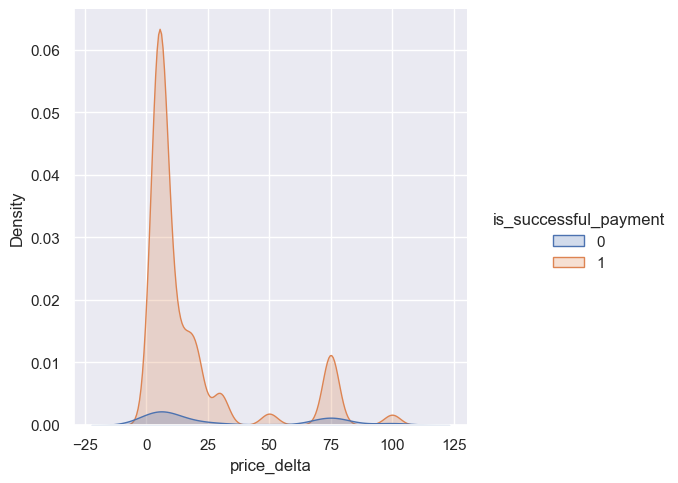

In [306]:
sns.set(style="darkgrid")

data_slim = data[(data.price_delta > 1) & (data.price_delta < 100)]\
                [['price_delta', 'is_successful_payment']]

sns.displot(data_slim,
            x="price_delta", 
            hue="is_successful_payment", 
            kind="kde", 
            fill="true")
plt.show()

There is significant concentration of failed orders between 1 and 20 unit.

Density plot to visualize the distribution of orders where price delta is greater than 100 units and see how it relates to successful/failed orders

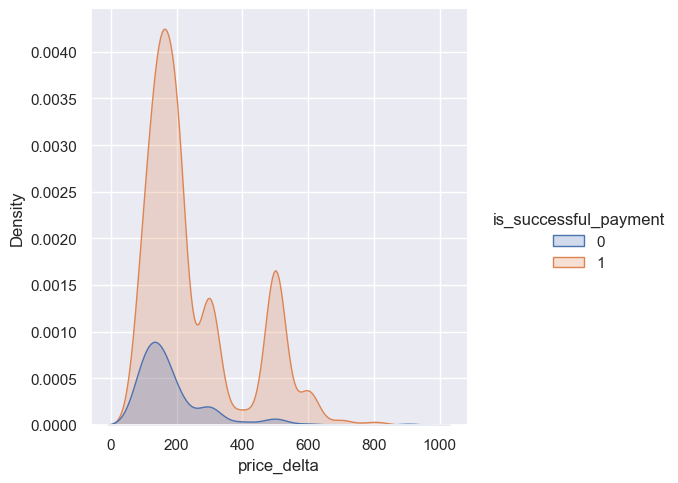

In [307]:
sns.set(style="darkgrid")

data_slim = data[(data.price_delta > 100) & (data.price_delta < 1000)]\
                [['price_delta', 'is_successful_payment']]

sns.displot(data_slim,
            x="price_delta", 
            hue="is_successful_payment", 
            kind="kde", 
            fill="true")
plt.show()

When price delta is between 100 and 250 there are high concentration of failed orders.

### <a id='f6'>6. Feature - distance_by_ride_distance</a>

Here we check how the driver distance is related to the ride distance when order's payment fails/succeed. <br>
Driver very near to the rider when booking a high price long distance ride could unveil cases where fraudsters attempt to spoof the gps locations of fake rider/driver profile for booking and monetization through stolen credit cards.

Calculating driver distance to ride distance ratio

In [308]:
data['distance_by_ride_distance'] = data['distance'] / data['ride_distance']

In [309]:
# Checking distribution of driver distance by ride distance ratio


data['distance_by_ride_distance'].describe()

count    242110.000000
mean          1.930454
std          82.420207
min           0.000000
25%           0.062713
50%           0.156243
75%           0.338159
max       29008.000000
Name: distance_by_ride_distance, dtype: float64

In [310]:
# 95 percentile value for driver by ride distance ratio

data['distance_by_ride_distance'].quantile(0.95)

0.86948364787044

<AxesSubplot: >

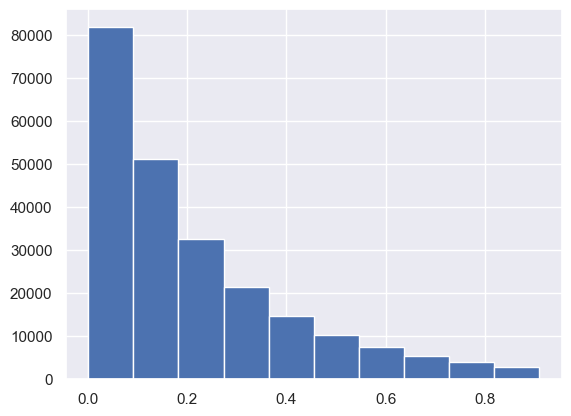

In [311]:
# Distribution for driver by ride distance below 0.91 (to remove skeweness)

data[(data.distance_by_ride_distance <= 0.91)]['distance_by_ride_distance'].hist()

We see above that for most of the rides the ratio is within 0.4

Density plot for ratio value greater than 0.91

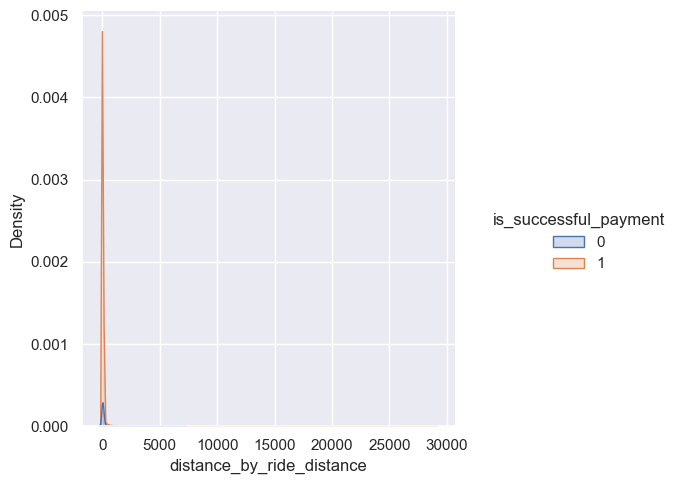

In [312]:
sns.set(style="darkgrid")

data_slim = data[(data.distance_by_ride_distance > 0.91) ]\
            [['distance_by_ride_distance', 'is_successful_payment']]


sns.displot(data_slim,
            x="distance_by_ride_distance", 
            hue="is_successful_payment", 
            kind="kde", 
            fill="true")
plt.show()

Re-calculating the plot with cap on maximum ratio value (limiting to 2)

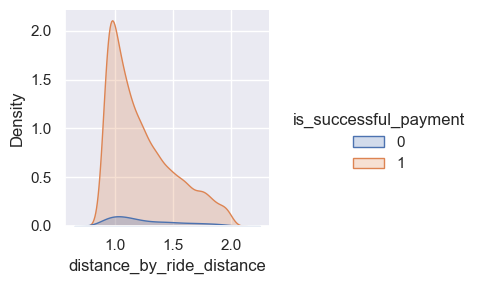

In [313]:
sns.set(style="darkgrid")

data_slim = data[(data.distance_by_ride_distance > 0.91) & \
                (data.distance_by_ride_distance < 2)]\
            [['distance_by_ride_distance', 'is_successful_payment']]


sns.displot(data_slim,
            x="distance_by_ride_distance", 
            hue="is_successful_payment", 
            kind="kde", 
            fill="true", height=3)
plt.show()

We see there is significant concentration of failed orders from 0.8 to 1.4 range of ratio value

Density plot for distance by ride distance ratio value within 0.91

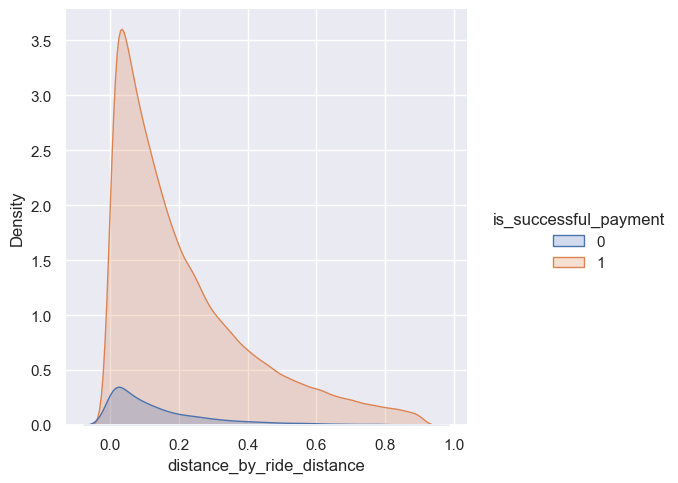

In [314]:
sns.set(style="darkgrid")

data_slim = data[(data.distance_by_ride_distance < 0.91) ]\
            [['distance_by_ride_distance', 'is_successful_payment']]


sns.displot(data_slim,
            x="distance_by_ride_distance", 
            hue="is_successful_payment", 
            kind="kde", 
            fill="true")
plt.show()

Let's break this segment further to - orders with price delta as zero/non-zero

Density plot for ratio value below 0.91 and price delta as non-zero

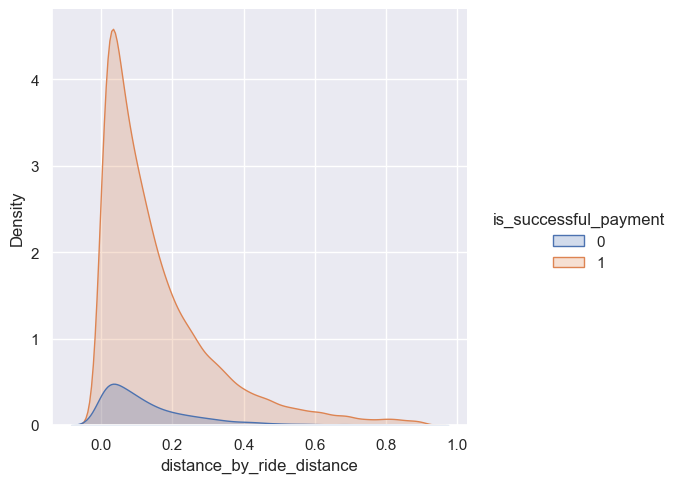

In [315]:
sns.set(style="darkgrid")

data_slim = data[(data.price_delta != 0) &\
                 (data.distance_by_ride_distance <= 0.91)]\
            [['distance_by_ride_distance', 'is_successful_payment']]


sns.displot(data_slim,
            x="distance_by_ride_distance", 
            hue="is_successful_payment", 
            kind="kde", 
            fill="true")
plt.show()

We see there is significant concentration of failed orders from value range 0.0 to 0.4

Density plot for ratio value below 0.91 and price delta as 0

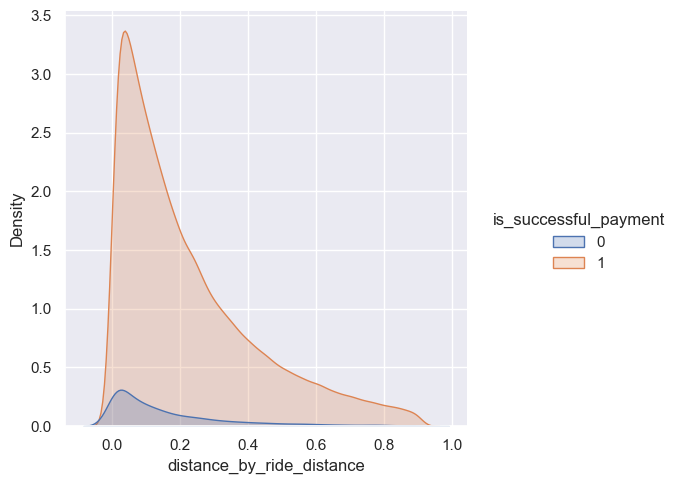

In [316]:
sns.set(style="darkgrid")

data_slim = data[(data.price_delta == 0) &\
                 (data.distance_by_ride_distance <= 0.91) ]\
            [['distance_by_ride_distance', 'is_successful_payment']]


sns.displot(data_slim,
            x="distance_by_ride_distance", 
            hue="is_successful_payment", 
            kind="kde", 
            fill="true")
plt.show()

Let's re-calculate the density plot with lower cut-off for ratio value (0.006) and price delta as 0

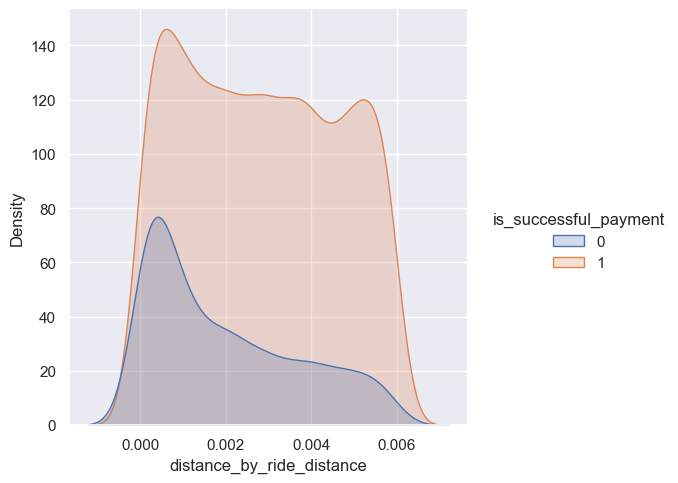

In [317]:
sns.set(style="darkgrid")

data_slim = data[(data.price_delta == 0) &\
                 (data.distance_by_ride_distance <= 0.006) ]\
            [['distance_by_ride_distance', 'is_successful_payment']]


sns.displot(data_slim,
            x="distance_by_ride_distance", 
            hue="is_successful_payment", 
            kind="kde", 
            fill="true")
plt.show()

We see above that for ratio value below 0.006 there is significant concentration of failed orders. 

### <a id='f7'>7. Feature - failed_attempts_gt_3</a>

Here we check how number of failed attempts related to order success/failure. <br>
After several fraud attempts there are high chances of order payment getting failed because of card network barring the payment because of multiple retries. Also it could reveal fraudulent activity attempting to pay through stolen credit card even after repeated failures.

In [318]:
# Checking the distribution of no. of failed attempts

data['failed_attempts'].describe()

count    242110.000000
mean          0.355087
std           1.016558
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          42.000000
Name: failed_attempts, dtype: float64

In [319]:
# Distribution for each failed attempts and how it correlates with order success/failure

pd.crosstab(data.failed_attempts, data.is_successful_payment)

is_successful_payment,0,1
failed_attempts,,
0,11303,181174
1,2943,29788
2,1156,8103
3,590,2957
4,374,1313
5,216,650
6,140,409
7,103,208
8,66,136


We can see that chances of order failues increases with increased number of failed attempts.

Density plot to understand the distribution of orders where number of failed attemts is greater than
equal to 3 when price presented as not null, and how it relates to order success/failure

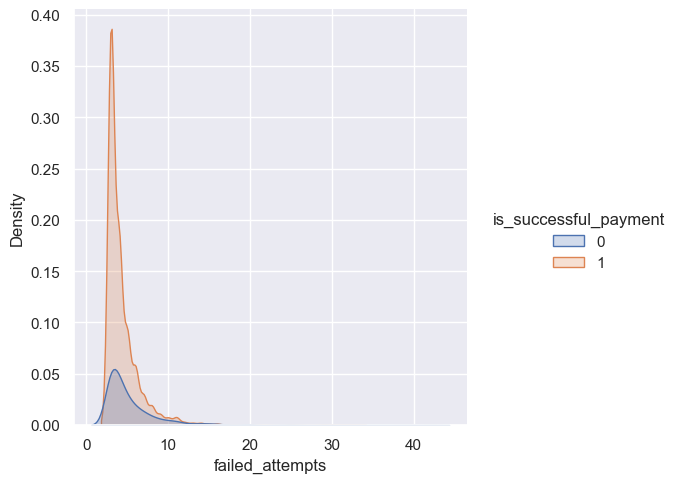

In [320]:
sns.set(style="darkgrid")

data_slim = data[(data.failed_attempts >= 3)][['failed_attempts', 'is_successful_payment']]


sns.displot(data_slim,
            x="failed_attempts", 
            hue="is_successful_payment", 
            kind="kde", 
            fill="true")
plt.show()

We can see above there is significant concentration of no. of failed attempts equals to and above the
cut-off of 3. Let's understand the risk associated at this cut-off.

Indicator for no. of failed attempts greater than equals to 3

In [324]:
data['failed_attempts_gt_3'] = data['failed_attempts'].apply(lambda x: 1 if(x>=3) else 0)

### <a id='f9'>8. Feature - failure Rate</a>

Here we calculate the failure risk associated with different entities (device name, device os version and card bin ). <br>
Entities with 100% failure rate could be denied the order to avoid failures. Entities with high failure risk could be requested to use alternate device or cards for payments.

In [325]:
def calc_fail_rate(column, df):
    t = pd.crosstab(df[column], df.is_successful_payment).reset_index()
    t.columns = [column, 'fail', 'success']
    t[column+'_fail_rate'] = t['fail'] / (t['fail'] + t['success'])
    return t

In [326]:
df1 = calc_fail_rate('device_name', data)
df1.head()

,device_name,fail,success,device_name_fail_rate
0,1,11,405,0.026442
1,3QRC7802F,0,1,0.000000
2,4Good4Good Light A103,0,1,0.000000
3,4Good4Good S450m 4G,0,1,0.000000
4,77X77X,0,1,0.000000


In [327]:
df2 = calc_fail_rate('device_os_version', data)
df2

,device_os_version,fail,success,device_os_version_fail_rate
0,3Q4.2.2,0,1,0.000000
1,4Good5.1,0,1,0.000000
2,4Good6.0,0,1,0.000000
3,77X4.4.2,0,1,0.000000
4,A17.0,0,1,0.000000
...,...,...,...,...
1095,vivo6.0,2,4,0.333333
1096,vivo6.0.1,0,4,0.000000
1097,vkworld5.1,0,1,0.000000
1098,xiaomi7.1.2,1,5,0.166667


In [328]:
df3 = calc_fail_rate('card_bin', data)
df3

,card_bin,fail,success,card_bin_fail_rate
0,370276.0,2,4,0.333333
1,370277.0,1,2,0.333333
2,370285.0,0,1,0.000000
3,370286.0,1,0,1.000000
4,370288.0,1,0,1.000000
...,...,...,...,...
7450,559767.0,0,1,0.000000
7451,559828.0,0,1,0.000000
7452,559864.0,0,1,0.000000
7453,559996.0,1,1,0.500000


In [329]:
df4 = calc_fail_rate('coords', dataf)
df4[(df4.success > 0)]

,coords,fail,success,coords_fail_rate
2,-0.793452:37.308411,0,1,0.0
4,-1.009736:37.064878,0,1,0.0
5,-1.036322:37.076757,0,1,0.0
6,-1.037191:37.073417,0,1,0.0
11,-1.101679:37.014792,0,1,0.0
...,...,...,...,...
231388,65.071241:25.513116,0,1,0.0
231389,65.071351:25.520084,0,1,0.0
231390,65.072586:25.476903,0,1,0.0
231391,65.087854:25.408013,0,1,0.0


In [330]:
df4['coords_fail_rate'] = df4.apply(lambda x: 0 if(x.success == 0) else x.coords_fail_rate, axis=1)

In [331]:
data=pd.merge(data,df1[['device_name','device_name_fail_rate']], how='left', on='device_name')
data=pd.merge(data,df2[['device_os_version','device_os_version_fail_rate']], how='left', on='device_os_version')
data=pd.merge(data,df3[['card_bin','card_bin_fail_rate']], how='left', on='card_bin')
data

,created,device_name,device_os_version,country,city_id,lat,lng,real_destination_lat,real_destination_lng,user_id,...,card_bin,failed_attempts,cd,reason_cd,price_delta,distance_by_ride_distance,failed_attempts_gt_3,device_name_fail_rate,device_os_version_fail_rate,card_bin_fail_rate
0,2016-01-23 23:10:07,motorolaXT1562,motorola6.0.1,ee,2.0,58.378220,26.710402,58.363243,26.737696,218,...,NaN,0,0,0,0.0,0.256215,0,0.022989,0.261584,NaN
1,2016-05-04 06:01:32,iPhone6,iOS10.3.3,ee,1.0,59.424130,24.646359,59.397548,24.660957,266,...,NaN,0,0,0,0.0,0.010139,0,0.042930,0.033317,NaN
2,2016-08-27 16:42:22,HTCHTC 10,HTC7.0,ee,1.0,59.413508,24.743706,59.448500,24.804887,551,...,516903.0,0,0,0,0.0,0.260596,0,0.028481,0.039024,0.020474
3,2016-10-25 07:14:27,iPhone6S,iOS10.3.2,ee,1.0,59.419938,24.744795,59.431686,24.720801,798,...,541747.0,0,0,0,0.0,0.334723,0,0.034322,0.036574,0.006263
4,2016-09-09 12:46:47,"iPhone5,2",iOS9.3.4,ee,1.0,59.471328,24.890557,59.427836,24.774460,944,...,NaN,0,0,0,0.0,0.107795,0,0.116578,0.072301,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242105,2017-06-21 05:05:50,iPhone6S,iOS10.2.1,za,54.0,-25.746974,28.114173,-25.748204,28.132867,1916704,...,523982.0,0,8,0,0.0,0.791842,0,0.034322,0.066711,0.033871
242106,2017-07-03 12:34:48,iPhone6,iOS10.3.2,ge,15.0,41.709336,44.802954,41.693171,44.803201,2017910,...,431572.0,0,4,0,0.0,0.153574,0,0.042930,0.036574,0.000000
242107,2017-07-25 14:00:26,BoostShaker-Slim,Boost4.4.2,za,54.0,-26.077051,28.084813,-26.095041,28.080559,2086329,...,425668.0,0,8,0,0.0,0.533379,0,0.000000,0.000000,0.097614
242108,2017-07-30 14:11:14,iPhone6,iOS10.3.2,ro,325.0,44.441192,26.020226,44.435512,26.116617,2161013,...,554593.0,0,14,0,0.0,0.177482,0,0.042930,0.036574,0.076923


In [333]:
data['coords'] = data['lat'].astype(str) + ':' + data['lng'].astype(str)

In [345]:
data=pd.merge(data,df4[['coords','coords_fail_rate']], how='left', on='coords')

### <a id='f9'>9. Additional Features</a>

In [346]:
data['ride_price_by_price'] = data['ride_price']/data['price']

In [347]:
data['fractional_ride_price'] = data['ride_price'].apply(lambda x: 1 if(int(str(x).split('.')[1]) > 0) else 0)

data['fractional_price'] = data['price'].apply(lambda x: 1 if(int(str(x).split('.')[1]) > 0) else 0)

In [348]:
data['source_target_coords_ratio'] = (data['lat']*data['lng']) / (data['real_destination_lat']*data['real_destination_lng'])

In [349]:
data['rounded_ride_price'] = data['ride_price'].apply(lambda x: 1 if(x%10 == 0) else 0)
data['rounded_price'] = data['price'].apply(lambda x: 1 if(x%10 == 0) else 0)

In [380]:
data.columns

Index(['created', 'device_name', 'device_os_version', 'country', 'city_id',
       'lat', 'lng', 'real_destination_lat', 'real_destination_lng', 'user_id',
       'order_id', 'order_try_id', 'distance', 'ride_distance', 'price',
       'ride_price', 'price_review_status', 'price_review_reason',
       'is_successful_payment', 'name', 'card_bin', 'failed_attempts', 'cd',
       'reason_cd', 'price_delta', 'distance_by_ride_distance',
       'failed_attempts_gt_3', 'device_name_fail_rate',
       'device_os_version_fail_rate', 'card_bin_fail_rate', 'coords',
       'ride_price_by_price', 'fractional_ride_price', 'fractional_price',
       'source_target_coords_ratio', 'rounded_ride_price', 'rounded_price',
       'coords_fail_rate'],
      dtype='object')

In [351]:
for col in data.columns:
    data[col] = data[col].fillna(-999.0)

### <a> Analysis and Modelling using XG Boost </a>

In [408]:
X=data[['city_id', 'price',
        'distance', 'ride_distance', 'ride_price_by_price',
        'ride_price','price_delta',
    'card_bin_fail_rate', 
         'cd', 'failed_attempts',
        'device_name_fail_rate', 'device_os_version_fail_rate',
         'card_bin',
        'coords_fail_rate','rounded_price',
         'distance_by_ride_distance',
      ]]
Y= data['is_successful_payment'].apply(lambda x: 1 if(x == 0) else 0)

In [409]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=16)

In [410]:
model = XGBClassifier()
model.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [357]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

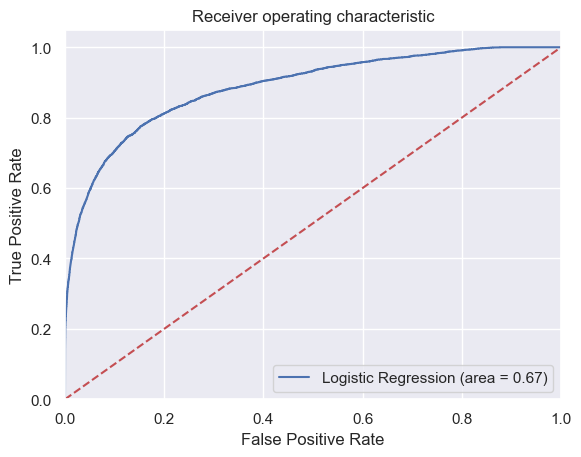

In [411]:
logit_roc_auc = roc_auc_score(Y_test, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(Y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [412]:
Y_pred = model.predict(X_test)

In [413]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y_test, Y_pred)
print(confusion_matrix)

[[55695   504]
 [ 2781  1548]]


In [414]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     56199
           1       0.75      0.36      0.49      4329

    accuracy                           0.95     60528
   macro avg       0.85      0.67      0.73     60528
weighted avg       0.94      0.95      0.94     60528



In [415]:
X_test['prob'] =  model.predict_proba(X_test)[:,1]

In [416]:
X_test['label'] = Y_test

In [417]:
X_test['label'].value_counts()

0    56199
1     4329
Name: label, dtype: int64

In [418]:
# Model Threshold score 0.15
X_test[(X_test.prob >= 0.15)]['label'].value_counts()

0    3797
1    2797
Name: label, dtype: int64

In [419]:
#So, 2797 are actual frauds detected by the model.

In [420]:
#detection rate
2797/4329

0.6461076461076461

In [421]:
# false positive ratio
3797/56199

0.06756347977722023

In [378]:
import numpy as np

Text(0.5, 1.0, 'Feature Importance')

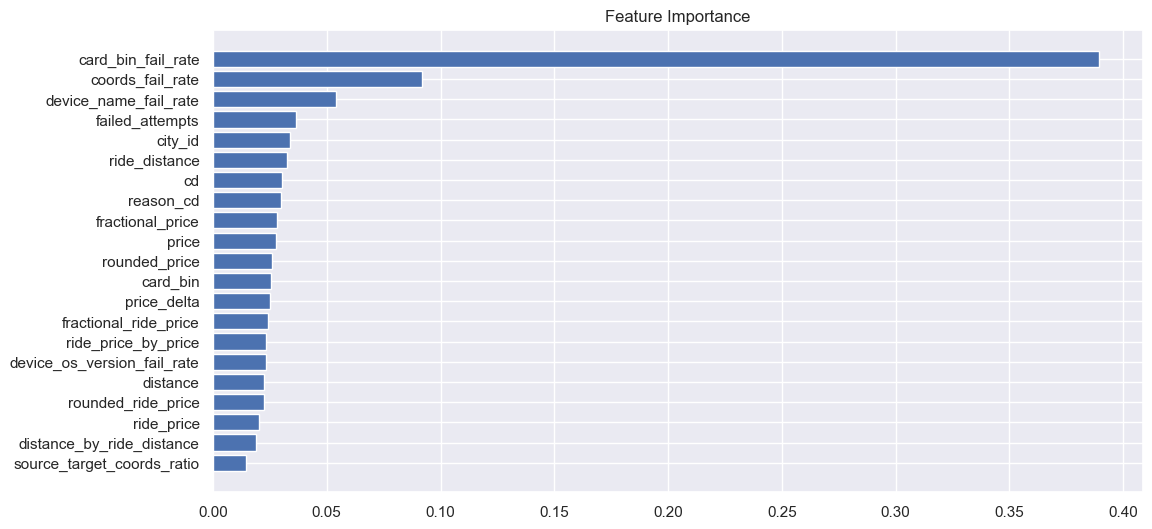

In [405]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

### <a> Analysis and Modelling using Logistic Regression </a>

In [371]:
X=data[['city_id', 'price',
        'distance', 'ride_distance', 'ride_price_by_price',
        'ride_price','price_delta', 
    'card_bin_fail_rate', 
         'cd', 'failed_attempts',
        'device_name_fail_rate', 'device_os_version_fail_rate',
         'card_bin',
        'coords_fail_rate','rounded_price',
         'distance_by_ride_distance',
      ]]
Y= data['is_successful_payment'].apply(lambda x: 1 if(x == 0) else 0)

In [373]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=16)

In [374]:
modelLogistic = LogisticRegression()
modelLogistic.fit(X_train,Y_train)
#print the regression coefficients

print("The intercept b0= ", modelLogistic.intercept_)

print("The coefficient b1= ", modelLogistic.coef_)

The intercept b0=  [-6.85299977e-06]
The coefficient b1=  [[ 3.16732437e-03 -7.75125881e-05  6.70512096e-07  4.15815917e-05
   1.73483923e-04  8.16285690e-05  1.59141157e-04  3.00421983e-03
   1.71188485e-04  5.84941606e-05  1.42339917e-05  6.51468960e-06
  -7.00488520e-06  3.08713480e-06  2.10581397e-06  1.85118423e-04]]


C:\Users\richa\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [375]:
Y_pred= modelLogistic.predict(X_test)

In [376]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y_test, Y_pred)
print(confusion_matrix)

[[56141    58]
 [ 4177   152]]


In [377]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     56199
           1       0.72      0.04      0.07      4329

    accuracy                           0.93     60528
   macro avg       0.83      0.52      0.52     60528
weighted avg       0.92      0.93      0.90     60528

